In [ ]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import copy
import glob
import random

# Multiple sources in single time-window

In this notebook we analyse the output of the DL model for the situation where there is more than a single event present in the time-window. The DL model was only trained with time-windows where a single event was present. Therefore, it is interesting to observe what happens when more than one event is present. We play around with different settings: Both events have the same strength or they have different strengths

In [ ]:
path_model = "drive/My Drive/Texas_TL/TL_models/TL_TFR_regular_updating/QNet_0.h5"
path_synthetics = "drive/My Drive/Texas_TL/Data/SyntheticData"
fn_synth1 = "texas_synth_7739_4924_2529.npy"
fn_synth2 = "texas_synth_6909_4174_2574.npy"

In [ ]:
# Define locations of events
x1, y1, z1 = 7739, 4924, 2529-400
x2, y2, z2 = 6909, 4174, 2574-400

In [ ]:
# Load model
def dice_coef_gaussian(y_true, y_pred, smooth=1):
  y_true = tf.dtypes.cast(y_true>0.1, tf.int32)
  y_true = tf.dtypes.cast(y_true, tf.float32)
  y_pred = tf.dtypes.cast(y_pred>0.1, tf.int32)
  y_pred = tf.dtypes.cast(y_pred, tf.float32)
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_coef(y_true, y_pred, smooth=1):
  y_true = tf.dtypes.cast(y_true, tf.float32)
  y_pred = tf.dtypes.cast(y_pred, tf.float32)
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

# Clip values in Gaussian above 0.1 to 1 and below 0.1 to 0
def iou_coef_gaussian(y_true, y_pred, smooth=1):
    y_true = tf.dtypes.cast(y_true>0.1, tf.int32)
    y_true = tf.dtypes.cast(y_true, tf.float32)
    y_pred = tf.dtypes.cast(y_pred>0.1, tf.int32)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

QNet = tf.keras.models.load_model(
    path_model,
    custom_objects={
        'ReLU':tf.keras.layers.ReLU, 'dice_coef_gaussian': dice_coef_gaussian, 
        'iou_coef_gaussian': iou_coef_gaussian, 'dice_coef': dice_coef,
    }
)

In [ ]:
# Define functions to prepare data for input
def interp_time(data):

  # interpolate to 1024 time samples (from 1401)
  dt = 0.002
  t = np.arange(0,1401)*dt
  tn = np.linspace(0,t[-1],1024)
  dtn = tn[1]-tn[0]
  x_new = np.zeros((len(tn),data.shape[1]))
  for i in range(x_new.shape[1]):
    x_new[:,i] = np.interp(tn, t, data[:,i])

  return x_new

def prepare_data(data):
  data = data/np.max(np.abs(data)) # normalize
  data = np.reshape(data, (1, data.shape[0], data.shape[1],1))

  return data

Define function to plot data

In [ ]:
def wiggle(
    DataO: np.ndarray,
    x=None,
    t=None,
    ax=None,
    skipt=1,
    lwidth=.5,
    gain=1,
    typeD='VA',
    color='red',
    perc=100):

    """
    wiggle(DataO, x=None, t=None, maxval=-1, skipt=1, lwidth=.5, gain=1, typeD='VA', color='red', perc=100)

    This function generates a wiggle plot of the seismic data.

    Parameters
    ----------
    DataO: np.ndarray of shape (# time samples, # traces)
        Seismic data

    Optional parameters
    -------------------
    x: np.ndarray of shape Data.shape[1]
        x-coordinates to Plot
    t: np.ndarray of shape Data.shap[0]
        t-axis to plot
    skipt: int
        Skip trace, skips every n-th trace
    ldwidth: float
        line width of the traces in the figure, increase or decreases the traces width
    typeD: string
        With or without filling positive amplitudes. Use type=None for no filling
    color: string
        Color of the traces
    perc: float
        nth parcintile to be clipped

    Returns
    -------
    Seismic wiggle plot

    Adapted from segypy (Thomas Mejer Hansen, https://github.com/cultpenguin/segypy/blob/master/segypy/segypy.py)


    """
    # Make a copy of the original, so that it won't change the original one ouside the scope of the function
    Data = copy.copy(DataO)

    # calculate value of nth-percentile, when perc = 100, data won't be clipped.
    nth_percentile = np.abs(np.percentile(Data, perc))

    # clip data to the value of nth-percentile
    Data = np.clip(Data, a_min=-nth_percentile, a_max = nth_percentile)

    ns = Data.shape[0]
    ntraces = Data.shape[1]

    #fig = plt.gca()
    ax = ax or plt.gca()
    ntmax=1e+9 # used to be optinal

    if ntmax<ntraces:
        skipt=int(np.floor(ntraces/ntmax))
        if skipt<1:
                skipt=1

    if x is not None:
        x=x
        ax.set_xlabel('Distance [m]', fontsize=16)
    else:
        x=range(0, ntraces)
        ax.set_xlabel('Trace number', fontsize=16)

    if t is not None:
        t=t
        yl='Time [s]'
    else:
        t=np.arange(0, ns)
        yl='Sample number'

    dx = x[1]-x[0]

    Dmax = np.nanmax(Data)
    maxval = np.abs(Dmax)

    for i in range(0, ntraces, skipt):

       # use copy to avoid truncating the data
        trace = copy.copy(Data[:, i])
        trace = Data[:, i]
        trace[0] = 0
        trace[-1] = 0
        traceplt = x[i] + gain * skipt * dx * trace / maxval
        traceplt = np.clip(traceplt, a_min=x[i]-dx, a_max=(dx+x[i]))

        ax.plot(traceplt, t, color=color, linewidth=lwidth)

        offset = x[i]

        if typeD=='VA':
            for a in range(len(trace)):
                if (trace[a] < 0):
                    trace[a] = 0
            ax.fill_betweenx(t, offset, traceplt, where=(traceplt>offset), interpolate='True', linewidth=0, color=color)
            ax.grid(False)

        ax.set_xlim([x[0]-1, x[-1]+1])

    ax.invert_yaxis()
    ax.set_ylim([np.max(t), np.min(t)])
    ax.set_ylabel(yl, fontsize=16)


    return ax

Load events, interpolate time, and combine in same time-window

In [ ]:
# Load synthetic data
synth1 = np.load(os.path.join(path_synthetics, fn_synth1))
synth2 = np.load(os.path.join(path_synthetics, fn_synth2))

synth1 = interp_time(synth1)
synth2 = interp_time(synth2)
synth2 = np.roll(synth2, shift=-160, axis=0)

synth_comb = synth1+synth2
synth_comb = synth_comb/np.max(np.abs(synth_comb))

Add field noise to synthetics and prepare input for QNet

In [ ]:
def full_field_noise(data):

  files = glob.glob("drive/My Drive/Texas_TL/Data/contNoise_newShape/*")
  fn = files[20]#random.choice(files)
  noise = np.load(fn)

  # pick random time-window
  idx = 2862#random.choice(np.arange(0,noise.shape[0]-1024))
  noise = noise[idx:idx+1024, :]
  noise = noise/np.max(np.abs(noise))

  noise_new = 3*noise#np.random.uniform(1,3)*noise
  noise = np.reshape(noise, (noise.shape[0], noise.shape[1], 1))
  data = (data/np.max(np.abs(data)))+noise_new

  return data

In [ ]:
synth_comb = full_field_noise(synth_comb)
synth_comb = prepare_data(synth_comb)

Visualize network output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


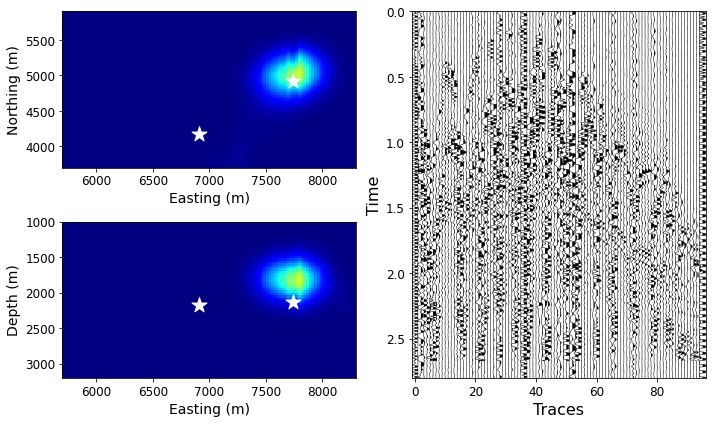

In [ ]:
xs = np.linspace(5500,8500,128)
ys = np.linspace(3500,6100,96)
zs = np.linspace(1000,3200,64)


# Make prediction     
prediction = QNet.predict(synth_comb)[0,:]
maxIdx = np.unravel_index(np.argmax(prediction), prediction.shape)
  
fig = plt.figure(constrained_layout=True, figsize=(10,6))
gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])
im1 = ax1.pcolormesh(xs,ys,prediction[:,:,maxIdx[2]].T, cmap=plt.cm.jet, vmin=0, vmax=1)
ax1.set_xlabel('Easting (m)', fontsize=14)
ax1.set_ylabel('Northing (m)', fontsize=14)
ax1.scatter(x1, y1, marker='*', color='white',s=250)
ax1.scatter(x2, y2, marker='*', color='white',s=250)
ax1.set_xlim([5700, 8300])
ax1.set_ylim([3700, 5900])
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

im2 = ax2.pcolormesh(xs,zs,prediction[:,maxIdx[1],:].T, cmap=plt.cm.jet, vmin=0.0, vmax=1)
ax2.set_xlabel('Easting (m)', fontsize=14)
ax2.set_ylabel('Depth (m)', fontsize=14)
ax2.scatter(x1, z1, marker='*', color='white',s=250)
ax2.scatter(x2, z2, marker='*', color='white',s=250)
ax2.set_xlim([5700, 8300])
ax2.set_ylim([1000, 3200])
ax2.invert_yaxis()
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

wiggle(synth_comb[0,:,:,0], t=np.linspace(0,2.8,synth_comb.shape[1]), perc=97, color='k', ax=ax3)
ax3.set_xlabel('Traces')
ax3.set_ylabel('Time')
ax3.tick_params(axis='x', labelsize=12)
ax3.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.savefig('drive/My Drive/Texas_TL/Figures/two_events_same_timeShifted.png')
#plt.close()